In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.preprocessing import Imputer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import scipy.stats as ss
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import LeaveOneOut
import mifs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import scipy
import numpy as np, scipy.stats as st
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from scipy import interp
from collections import Counter
# import warnings filter
from warnings import simplefilter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import balanced_accuracy_score

from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
import string


In [3]:
#load data from MIMIC 3
admissions=pd.read_csv('ADMISSIONS.csv')
patient=pd.read_csv('PATIENTS.csv')
lab=pd.read_csv('LABEVENTS.csv')

In [82]:
notes=pd.read_csv('NOTEEVENTS.csv')

/root/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [83]:
# filter to discharge summary
df_notes_dis_sum = notes.loc[notes.CATEGORY == 'Discharge summary']

In [84]:
#group the notes by SUBJECT and HADM ID
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

In [85]:
#subset admissions data for sepsis patients only
admission_sepsis=admissions[admissions.DIAGNOSIS=="SEPSIS"]

In [86]:
admission_sepsis.ADMITTIME = pd.to_datetime(admission_sepsis.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admission_sepsis.DISCHTIME = pd.to_datetime(admission_sepsis.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admission_sepsis.DEATHTIME = pd.to_datetime(admission_sepsis.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
patient.DOB=pd.to_datetime(patient.DOB, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
lab.CHARTTIME=pd.to_datetime(lab.CHARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

/root/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/semaphore_tracker.py:74: UserWarning: semaphore_tracker: process died unexpectedly, relaunching.  Some semaphores might leak.
  warnings.warn('semaphore_tracker: process died unexpectedly, '
/root/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [87]:
admission_sepsis['mortality_period']=admission_sepsis.DEATHTIME-admission_sepsis.ADMITTIME

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
adm_col = ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'ETHNICITY', 'mortality_period']
admission_sepsis = admission_sepsis[adm_col]
admission_sepsis['mortality_period']=admission_sepsis['mortality_period'].dt.days


In [89]:
admission_sepsis['LABEL'] = (admission_sepsis['mortality_period']< 30).astype('int')

In [90]:
admission_sepsis.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,INSURANCE,ETHNICITY,mortality_period,LABEL
24,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,NaN,0
37,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,NaN,0
98,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,NaN,0
230,21,111970,2135-01-30 20:50:00,EMERGENCY,Medicare,WHITE,8.0,1
300,353,108923,2151-03-28 16:01:00,EMERGENCY,Medicare,WHITE,NaN,0
302,353,131488,2151-10-01 20:42:00,EMERGENCY,Medicare,WHITE,NaN,0
363,507,148905,2146-06-22 00:58:00,EMERGENCY,Medicare,WHITE,NaN,0
409,406,113900,2119-08-25 22:37:00,EMERGENCY,Medicaid,WHITE,NaN,0
410,406,171178,2120-09-17 05:03:00,EMERGENCY,Medicaid,WHITE,NaN,0
412,406,100765,2126-03-11 23:06:00,EMERGENCY,Medicare,WHITE,NaN,0


In [91]:
admission_sepsis.LABEL.value_counts()

0    932
1    252
Name: LABEL, dtype: int64

In [92]:
patients = patient[['SUBJECT_ID', 'GENDER', 'DOB']]

In [93]:
patient_admission = admission_sepsis.join(patients.set_index('SUBJECT_ID'), on='SUBJECT_ID')

In [94]:
patient_admission['age']=((patient_admission['ADMITTIME']-patient_admission['DOB']).dt.days)//365
patient_admission['AGE']=patient_admission['age'].apply(lambda x: 91 if(x < 0) else x)
patient_admission=patient_admission.drop('age',axis=1)

In [95]:
patient_admission.head(3)

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,INSURANCE,ETHNICITY,mortality_period,LABEL,GENDER,DOB,AGE
24,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,NaN,0,M,2135-03-22,63
37,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,NaN,0,M,2112-05-22,52
98,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,NaN,0,M,2101-09-20,74


In [96]:
positive = patient_admission[patient_admission['LABEL'] == 0]
negative = patient_admission[patient_admission['LABEL'] == 1]

/root/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


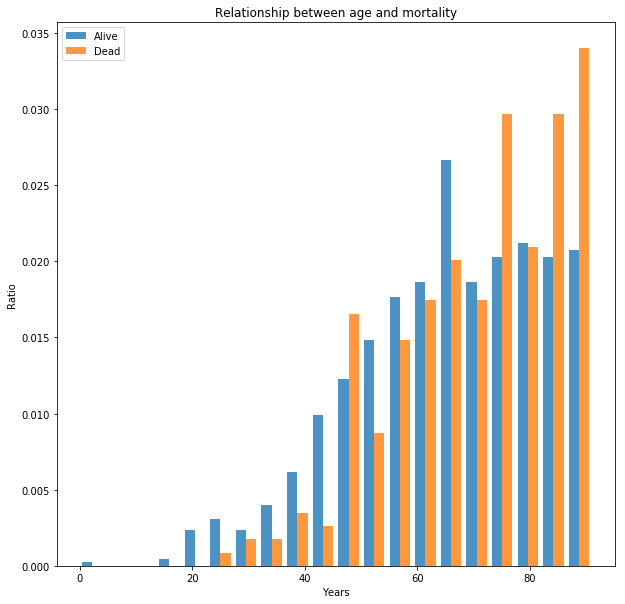

In [97]:
plt.figure(figsize=(10,10))
plt.hist([positive['AGE'],negative['AGE']], bins=20, alpha=0.8, normed=True, label=['Alive','Dead'])
plt.title('Relationship between age and mortality')
plt.xlabel('Years')
plt.ylabel('Ratio')
plt.legend(loc='upper left')

/root/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


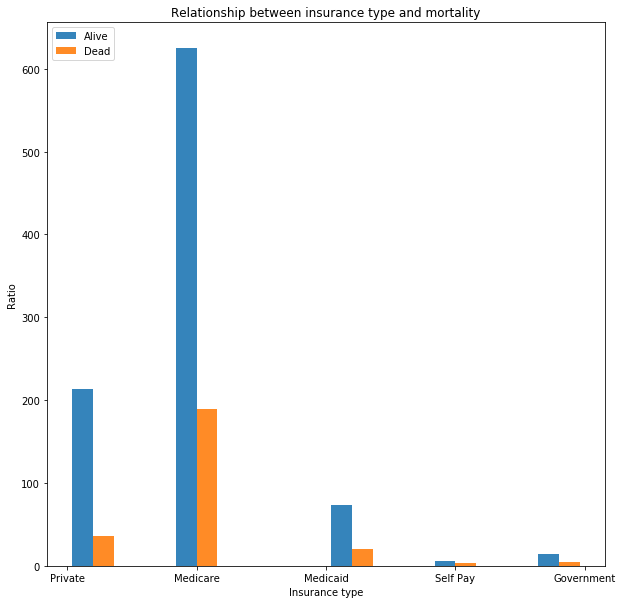

In [98]:
plt.figure(figsize=(10,10))
plt.hist([positive['INSURANCE'],negative['INSURANCE']], bins=10, alpha=0.9, normed=False, label=['Alive','Dead'])
plt.title('Relationship between insurance type and mortality')
plt.xlabel('Insurance type')
plt.ylabel('Ratio')
plt.legend(loc='upper left')

In [99]:
vitals={50882: 'bicarbonate' ,51237: 'INR' ,51248: 'MCH' ,50878: 'AST', 50863: 'alkaline phosphatase' ,50820: 'PH', 50912: 'creatinine', 51265: 'platelet', 51275: 'PT', 51274: 'PTT', 51244: 'lymphocytes', 51277:'RBCDW', 50893: 'calcium', 51256: 'neutrophils', 50931: 'glucose', 51221: 'hematocrit', 51222: 'hemoglobin', 50813: 'lactate', 51006: 'BUN'}

In [100]:
adm_id = patient_admission.HADM_ID.tolist()
lab_events=lab[lab['HADM_ID'].isin(adm_id)]
lab_events_1=lab_events[lab_events['ITEMID'].isin(vitals.keys())]

In [101]:
lab_events_1=lab_events_1.groupby('HADM_ID')

In [102]:
patient_admission.head(3)

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,INSURANCE,ETHNICITY,mortality_period,LABEL,GENDER,DOB,AGE
24,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,NaN,0,M,2135-03-22,63
37,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,NaN,0,M,2112-05-22,52
98,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,NaN,0,M,2101-09-20,74


In [103]:
# Prepare joining copy of patient vitals
patient_vitals = patient_admission[['HADM_ID']].copy()
for value in vitals.values():
    patient_vitals[value] = np.nan
    
patient_vitals = patient_vitals.set_index('HADM_ID')



In [104]:
patient_vitals.head(3)

,bicarbonate,INR,MCH,AST,alkaline phosphatase,PH,creatinine,platelet,PT,PTT,lymphocytes,RBCDW,calcium,neutrophils,glucose,hematocrit,hemoglobin,lactate,BUN
HADM_ID,,,,,,,,,,,,,,,,,,,
122609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
def resp_adjust(value):
    return max([int(x) for x in value.split('/') if x.isdigit()])

In [106]:
aday = pd.Timedelta('1 days')
# Each hospital stay, think of it as an individual patient (though technically not true)
for HADM_ID, group in lab_events_1:
    sub_groups = group.groupby('ITEMID')
    admittance_time = patient_admission.loc[patient_admission.HADM_ID==HADM_ID]['ADMITTIME'].values[0]
    # Each lab item type
    for lab_item, sub_group in sub_groups:
        day_results = sub_group[((sub_group.CHARTTIME - admittance_time) < aday)]
        # Unfortunate special case: If dirty respitory rate value, clean         
        if lab_item == 50827:
            cleaned_resp = map(resp_adjust, day_results['value'])
            mean =  np.mean(cleaned_resp)
        else:
            mean = day_results['VALUENUM'].values.mean()
        patient_vitals.set_value(HADM_ID, vitals[lab_item], mean)


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [115]:
admission_lab=patient_admission.merge(patient_vitals, on='HADM_ID')

In [116]:
stdsc = preprocessing.StandardScaler()
admission_lab[list(vitals.values())] = stdsc.fit_transform(admission_lab[list(vitals.values())])
admission_lab = admission_lab.fillna(patient_vitals.mean())

In [117]:
vital_columns =list(vitals.values())[:]
vital_columns.extend(['mortality_period'])
vitals_only = admission_lab[vital_columns]

<Figure size 1440x1440 with 0 Axes>

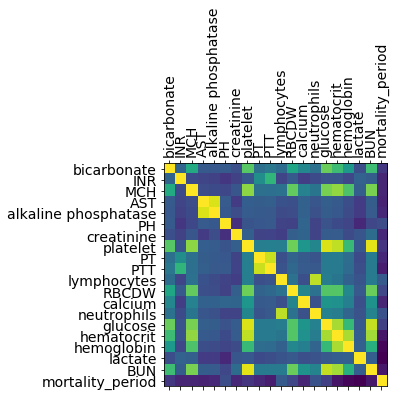

In [118]:
plt.figure(figsize=(20,20))
plt.matshow(vitals_only.corr())
plt.xticks(range(vitals_only.shape[1]),vitals_only.columns, fontsize=14, rotation=90)
plt.yticks(range(vitals_only.shape[1]), vitals_only.columns, fontsize=14)
plt.show()

In [32]:
#Learning models (using clinical and lab measurements features only)

In [35]:
y_vitals = admission_lab['LABEL']
X_vitals = admission_lab.drop(['LABEL', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ETHNICITY', 'DOB','mortality_period'], 1)
X_vitals = pd.get_dummies(X_vitals)

In [119]:
admission_lab.to_csv('clinical_vitals.csv')
y_vitals.to_csv('labels.csv')

In [39]:
#Random forests
param_grid = {"n_estimators": [200,400,600,800],'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7],
    'criterion' :['gini', 'entropy']}

forest = RandomForestClassifier( random_state=42)

In [40]:
rand_for = GridSearchCV(forest, param_grid, scoring = 'roc_auc',cv=10)
rand_for.fit(X_vitals,y_vitals)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 400, 600, 800], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [41]:
rand_for.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 600}

In [42]:
rand_for.best_score_

0.8163518531466369

In [43]:
#Decision trees
parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
clf_dt = GridSearchCV(DecisionTreeClassifier(), parameters, cv=10,scoring="roc_auc")
clf_dt.fit(X_vitals,y_vitals)

/root/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(10, 500, 20), 'max_depth': range(1, 20, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [44]:
clf_dt.best_params_

{'max_depth': 5, 'min_samples_split': 110}

In [45]:
clf_dt.best_score_

0.7509991273280567

In [46]:
#Logistic regression
logreg=LogisticRegression()
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(-3, 3, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
clf_logit = GridSearchCV(logreg, hyperparameters, cv=10, verbose=0,scoring="roc_auc")
clf_logit.fit(X_vitals,y_vitals)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-03, 4.64159e-03, 2.15443e-02, 1.00000e-01, 4.64159e-01,
       2.15443e+00, 1.00000e+01, 4.64159e+01, 2.15443e+02, 1.00000e+03]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [47]:
clf_logit.best_params_

{'C': 2.154434690031882, 'penalty': 'l2'}

In [48]:
clf_logit.best_score_

0.7877453243856811

In [49]:
#Naive Bayes
clf_gnb=GaussianNB().fit(X_vitals,y_vitals)
np.mean(cross_val_score(clf_gnb,X_vitals,y_vitals,scoring="roc_auc",cv=10))

0.65357429210003

In [50]:
#Adaboost
clf_ada=AdaBoostClassifier().fit(X_vitals,y_vitals)
np.mean(cross_val_score(clf_ada,X_vitals,y_vitals,scoring="roc_auc",cv=10))

0.757109339528008

In [54]:
#Gradient boosting
clf_gb=GradientBoostingClassifier(criterion='friedman_mse',learning_rate=0.15,max_depth=5,max_features='sqrt',min_samples_split=0.245,n_estimators=10).fit(X_vitals,y_vitals)
np.mean(cross_val_score(clf_gb,X_vitals,y_vitals,scoring="roc_auc",cv=10))

0.7791594424792778

In [55]:
sv_clf = SVC(random_state=42)

param_grid = {'C': [ 0.0001, 0.001, 0.01, 1, 100, 1000, 2000, 2500, 3000], 
              'gamma': [ 0.01, 0.001, 0.002, 0.003, 0.004, 0.005, 0.0001], 
              'kernel': ['rbf']
              }
grid_sv = GridSearchCV(sv_clf, param_grid, cv=10, scoring="roc_auc")
grid_sv.fit(X_vitals,y_vitals)
print(grid_sv.best_score_)
print(grid_sv.best_params_)
print(grid_sv.best_estimator_)

0.7837528437047998
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


/root/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [36]:
X_vitals.head(3)

,AGE,bicarbonate,INR,MCH,AST,alkaline phosphatase,PH,creatinine,platelet,PT,...,BUN,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,GENDER_F,GENDER_M
0,63,-1.023701,-0.346204,1.481840,-0.080886,-0.003543,7.329011,-0.153149,-1.138339,-0.519319,...,0.747578,1,0,0,0,0,1,0,0,1
1,52,0.739248,-0.516399,2.043873,-0.142401,-0.345127,7.329011,-0.113796,-0.228127,-0.524291,...,-0.837562,1,0,0,0,1,0,0,0,1
2,74,0.380508,-0.634227,1.850674,-0.102507,-0.488951,0.483689,-0.236107,-0.567417,-0.413900,...,-1.126725,1,0,0,0,1,0,0,0,1


In [56]:
importances = rand_for.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_vitals.shape[1]):
    print ("{}) {} {}".format(f, X_vitals.columns[indices[f]], importances[indices[f]]))



0) PH 0.13715513301186802
1) lactate 0.09763613762115024
2) bicarbonate 0.0874936562653367
3) BUN 0.06985422983870258
4) RBCDW 0.0579687072119808
5) calcium 0.04405627756205111
6) PT 0.041131593940348626
7) platelet 0.039585366801260416
8) creatinine 0.03940273107904974
9) neutrophils 0.03747261940404252
10) INR 0.03746756773477578
11) AGE 0.037219496518751026
12) AST 0.0361588123865119
13) glucose 0.03467372121890153
14) MCH 0.03385088723748777
15) PTT 0.03354166231119151
16) hematocrit 0.033243593742019885
17) hemoglobin 0.03172388593356736
18) lymphocytes 0.02861092731115317
19) alkaline phosphatase 0.02499185259548725
20) INSURANCE_Private 0.0039436227417674755
21) GENDER_F 0.0031639606397002823
22) INSURANCE_Medicare 0.003025989327699956
23) GENDER_M 0.002828370055445245
24) INSURANCE_Medicaid 0.0019829581780733286
25) INSURANCE_Government 0.000683614729907028
26) INSURANCE_Self Pay 0.0005991707892531986
27) ADMISSION_TYPE_URGENT 0.00033258804490056664
28) ADMISSION_TYPE_EMERGENCY

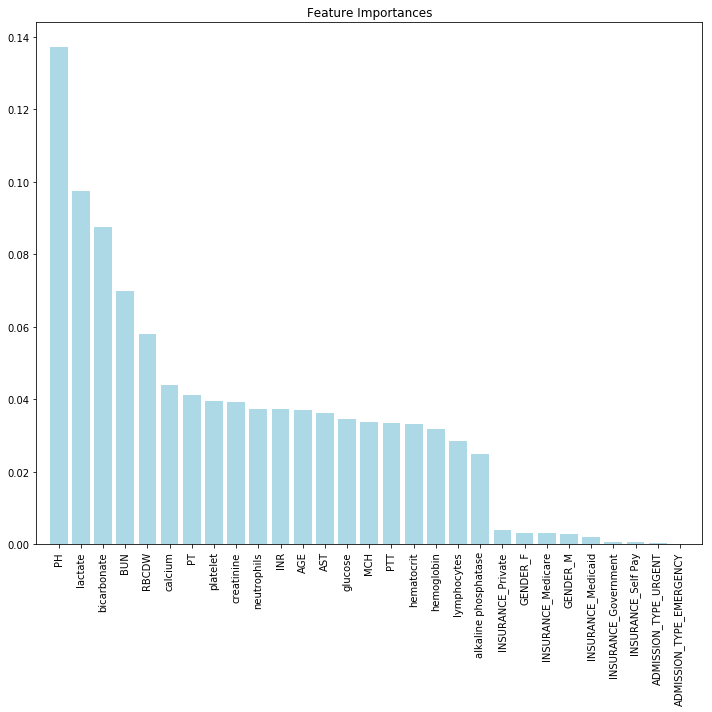

In [57]:
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.bar(range(X_vitals.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(X_vitals.shape[1]), X_vitals.columns[indices], rotation=90)
plt.xlim([-1, X_vitals.shape[1]])
plt.tight_layout()

In [114]:
admission_lab.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE',
       'ETHNICITY', 'mortality_period', 'LABEL', 'GENDER', 'DOB', 'AGE',
       'bicarbonate', 'INR', 'MCH', 'AST', 'alkaline phosphatase', 'PH',
       'creatinine', 'platelet', 'PT', 'PTT', 'lymphocytes', 'RBCDW',
       'calcium', 'neutrophils', 'glucose', 'hematocrit', 'hemoglobin',
       'lactate', 'BUN'],
      dtype='object')

In [113]:
admission_lab.to_csv("Admission_lab.csv")